In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import os
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

from IPython.display import Image
from time import sleep
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from pandas import DataFrame, Series
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from amb_sdk.sdk import DarwinSdk

%matplotlib inline

# Cleaning Data

In [2]:
data = pd.read_csv("speed-dating_raw.csv")
x = ['gender', 'race', 'race_o', 'field']
columns = list(data)

# Deleting bins
for column in columns:
    if column not in x and data[str(column)].dtype.name == 'object':
        del data[str(column)]

# Deleting useless columns        
del data['has_null']
del data['wave']
del data['d_age']
del data['samerace']
del data['expected_happy_with_sd_people']
del data['expected_num_interested_in_me']
del data['expected_num_matches']
del data['like']
del data['guess_prob_liked']
del data['decision']
del data['decision_o']

# Replace age NA with mean
mean = round(data['age'].mean())
data['age'].fillna(mean, inplace = True)
mean = round(data['age_o'].mean())
data['age_o'].fillna(mean, inplace = True)

# Make sure difference in age is correct
data['age_d'] = (data['age'] - data['age_o'])
data['age_d_abs'] = data['age_d'].abs()

# Replace race NA with other
data['race'].fillna('other', inplace= True)
data['race_o'].fillna('other', inplace = True)

# Verifying that same_race is correct with replaced race
data['same_race'] = (data['race'] == data['race_o'])

# Replace NA with 0 for preferences
preferences = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']          
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Renaming column names
data.rename(columns = {'importance_same_race':'same_race_i',
                       'importance_same_religion': 'same_religion_i',
                       'pref_o_attractive':'attractive_o_i',
                       'pref_o_sincere':'sincere_o_i',
                       'pref_o_intelligence':'intelligence_o_i',
                       'pref_o_funny':'funny_o_i',
                       'pref_o_ambitious':'ambitious_o_i',
                       'pref_o_shared_interests':'shared_interests_o_i',
                       'attractive_important':'attractive_i',
                       'sincere_important': 'sincere_i',
                       'intellicence_important': 'intelligence_i',
                       'funny_important':'funny_i',
                       'ambtition_important':'ambitious_i',
                       'shared_interests_important':'shared_interests_i',
                       'ambition':'ambitious',
                       'sinsere_o': 'sincere_o',
                       'ambitous_o':'ambitious_o',
                       'ambition_partner':'ambitious_partner'}, inplace = True)

# Making sure that opposite's importance columns add up to 100
data['o_i'] = data['attractive_o_i'] + data['sincere_o_i'] + data['intelligence_o_i'] + data['funny_o_i'] + data['ambitious_o_i'] + data['shared_interests_o_i']
data['attractive_o_i'] = (data['attractive_o_i'] / data['o_i'])
data['sincere_o_i'] = (data['sincere_o_i'] / data['o_i'])
data['intelligence_o_i'] = (data['intelligence_o_i'] / data['o_i'])
data['funny_o_i'] = (data['funny_o_i'] / data['o_i'])
data['ambitious_o_i'] = (data['ambitious_o_i'] / data['o_i'])
data['shared_interests_o_i'] = (data['shared_interests_o_i'] / data['o_i'])

# Making sure that my importance columns add up to 100
data['i'] = data['attractive_i'] + data['sincere_i'] + data['intelligence_i'] + data['funny_i'] + data['ambitious_i'] + data['shared_interests_i']
data['attractive_i'] = (data['attractive_i'] / data['i'])
data['sincere_i'] = (data['sincere_i'] / data['i'])
data['intelligence_i'] = (data['intelligence_i'] / data['i'])
data['funny_i'] = (data['funny_i'] / data['i'])
data['ambitious_i'] = (data['ambitious_i'] / data['i'])
data['shared_interests_i'] = (data['shared_interests_i'] / data['i'])

del data['o_i']
del data['i']

# Filling in data that are empty
temp = ['attractive_o_i', 'sincere_o_i', 'intelligence_o_i', 'funny_o_i', 'ambitious_o_i', 'shared_interests_o_i', 'attractive_i', 'sincere_i', 'intelligence_i', 'funny_i', 'ambitious_i', 'shared_interests_i']          
for t in temp:
    data[t].fillna((1.0 / 6.0), inplace = True)

# Replacing same_race_i & same_religion_i with mean (importance)
mean = data['same_race_i'].mean()
data['same_race_i'].fillna(round(mean), inplace = True)

mean = data['same_religion_i'].mean()
data['same_religion_i'].fillna(round(mean), inplace = True)

# One Hot Encoding of categorical data
data = pd.concat([data, pd.get_dummies(data['gender'], prefix = 'gender')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race'], prefix = 'race')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race_o'], prefix = 'race_o')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['field'], prefix = 'field')], axis = 1)

del data['gender']
del data['race']
del data['race_o']
del data['field']

# Label Encoding
le = LabelEncoder()
data['same_race'] = le.fit_transform(data['same_race'])

# Fill NA's with mean
mean = data['attractive_o'].mean()
data['attractive_o'].fillna(round(mean), inplace = True)
mean = data['sincere_o'].mean()
data['sincere_o'].fillna(round(mean), inplace = True)
mean = data['intelligence_o'].mean()
data['intelligence_o'].fillna(round(mean), inplace = True)
mean = data['funny_o'].mean()
data['funny_o'].fillna(round(mean), inplace = True)
mean = data['ambitious_o'].mean()
data['ambitious_o'].fillna(round(mean), inplace = True)
mean = data['shared_interests_o'].mean()
data['shared_interests_o'].fillna(round(mean), inplace = True)
mean = data['attractive'].mean()
data['attractive'].fillna(round(mean), inplace = True)
mean = data['sincere'].mean()
data['sincere'].fillna(round(mean), inplace = True)
mean = data['intelligence'].mean()
data['intelligence'].fillna(round(mean), inplace = True)
mean = data['funny'].mean()
data['funny'].fillna(round(mean), inplace = True)
mean = data['ambitious'].mean()
data['ambitious'].fillna(round(mean), inplace = True)
mean = data['attractive_partner'].mean()
data['attractive_partner'].fillna(round(mean), inplace = True)
mean = data['sincere_partner'].mean()
data['sincere_partner'].fillna(round(mean), inplace = True)
mean = data['intelligence_partner'].mean()
data['intelligence_partner'].fillna(round(mean), inplace = True)
mean = data['funny_partner'].mean()
data['funny_partner'].fillna(round(mean), inplace = True)
mean = data['ambitious_partner'].mean()
data['ambitious_partner'].fillna(round(mean), inplace = True)
mean = data['shared_interests_partner'].mean()
data['shared_interests_partner'].fillna(round(mean), inplace = True)
mean = data['met'].mean()
data['met'].fillna(round(mean), inplace = True)

# Delete rows with NA's for interests correlate
data = data.dropna(axis = 0, subset = ['interests_correlate'])

print(data.shape)
data.head()

(8220, 287)


,age,age_o,same_race_i,same_religion_i,attractive_o_i,sincere_o_i,intelligence_o_i,funny_o_i,ambitious_o_i,shared_interests_o_i,...,field_tc [health ed],field_teaching of english,field_tesol,field_theater,field_theatre management & producing,field_theory,field_undergrad - gs,field_urban planning,field_working,field_writing: literary nonfiction
0,21.0,27.0,2.0,4.0,0.35,0.20,0.20,0.20,0.00,0.05,...,0,0,0,0,0,0,0,0,0,0
1,21.0,22.0,2.0,4.0,0.60,0.00,0.00,0.40,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,21.0,22.0,2.0,4.0,0.19,0.18,0.19,0.18,0.14,0.12,...,0,0,0,0,0,0,0,0,0,0
3,21.0,23.0,2.0,4.0,0.30,0.05,0.15,0.40,0.05,0.05,...,0,0,0,0,0,0,0,0,0,0
4,21.0,24.0,2.0,4.0,0.30,0.10,0.20,0.10,0.10,0.20,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

In [3]:
# Difference between opposite's and my importance
data['attractive_i_d'] = (data['attractive_i'] - data['attractive_o_i'])
data['sincere_i_d'] = (data['sincere_i'] - data['sincere_o_i'])
data['intelligence_i_d'] = (data['intelligence_i'] - data['intelligence_o_i'])
data['funny_i_d'] = (data['funny_i'] - data['funny_o_i'])
data['ambitious_i_d'] = (data['ambitious_i'] - data['ambitious_o_i'])
data['shared_interests_i_d'] = (data['shared_interests_i'] - data['shared_interests_o_i'])

# Absolute difference of importance
data['attractive_i_d_abs'] = data['attractive_i_d'].abs()
data['sincere_i_d_abs'] = data['sincere_i_d'].abs()
data['intelligence_i_d_abs'] = data['intelligence_i_d'].abs()
data['funny_i_d_abs'] = data['funny_i_d'].abs()
data['ambitious_i_d_abs'] = data['ambitious_i_d'].abs()
data['shared_interests_i_d_abs'] = data['shared_interests_i_d'].abs()

# Difference between opposite's and my rating of me
data['attractive_d'] = (data['attractive'] - data['attractive_o'])
data['sincere_d'] = (data['sincere'] - data['sincere_o'])
data['intelligence_d'] = (data['intelligence'] - data['intelligence_o'])
data['funny_d'] = (data['funny'] - data['funny_o'])
data['ambitious_d'] = (data['ambitious'] - data['ambitious_o'])
data['shared_interests_d'] = (data['shared_interests_partner'] - data['shared_interests_o'])

# Absolute difference of rating
data['attractive_d_abs'] = data['attractive_d'].abs()
data['sincere_d_abs'] = data['sincere_d'].abs()
data['intelligence_d_abs'] = data['intelligence_d'].abs()
data['funny_d_abs'] = data['funny_d'].abs()
data['ambitious_d_abs'] = data['ambitious_d'].abs()
data['shared_interests_d_abs'] = data['shared_interests_d'].abs()

# Changing from [1-10] scale to percentage for opposite's rating
data['o'] = data['attractive_o'] + data['sincere_o'] + data['intelligence_o'] + data['funny_o'] + data['ambitious_o'] + data['shared_interests_o']
data['attractive_o_n'] = (data['attractive_o'] / data['o'])
data['sincere_o_n'] = (data['sincere_o'] / data['o'])
data['intelligence_o_n'] = (data['intelligence_o'] / data['o'])
data['funny_o_n'] = (data['funny_o'] / data['o'])
data['ambitious_o_n'] = (data['ambitious_o'] / data['o'])
data['shared_interests_o_n'] = (data['shared_interests_o'] / data['o'])

# Changing from [1-10] scale to percentage for my rating of opposite
data['p'] = data['attractive_partner'] + data['sincere_partner'] + data['intelligence_partner'] + data['funny_partner'] + data['ambitious_partner'] + data['shared_interests_partner']
data['attractive_p_n'] = (data['attractive_partner'] / data['p'])
data['sincere_p_n'] = (data['sincere_partner'] / data['p'])
data['intelligence_p_n'] = (data['intelligence_partner'] / data['p'])
data['funny_p_n'] = (data['funny_partner'] / data['p'])
data['ambitious_p_n'] = (data['ambitious_partner'] / data['p'])
data['shared_interests_p_n'] = (data['shared_interests_partner'] / data['p'])

del data['o']
del data['p']

# Filling in blanks with 0
preferences = ['attractive_o_n', 'sincere_o_n', 'intelligence_o_n', 'funny_o_n', 'ambitious_o_n', 'shared_interests_o_n', 'attractive_p_n', 'sincere_p_n', 'intelligence_p_n', 'funny_p_n', 'ambitious_p_n', 'shared_interests_p_n']
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Difference of rating percentage
data['d'] = data['attractive_d_abs'] + data['sincere_d_abs'] + data['intelligence_d_abs'] + data['funny_d_abs'] + data['ambitious_d_abs'] + data['shared_interests_d_abs']
data['attractive_d_n'] = (data['attractive_d'] / data['d'])
data['sincere_d_n'] = (data['sincere_d'] / data['d'])
data['intelligence_d_n'] = (data['intelligence_d'] / data['d'])
data['funny_d_n'] = (data['funny_d'] / data['d'])
data['ambitious_d_n'] = (data['ambitious_d'] / data['d'])
data['shared_interests_d_n'] = (data['shared_interests_d'] / data['d'])

del data['d']

# Absolute difference of rating percentage
data['attractive_d_n_abs'] = data['attractive_d_n'].abs()
data['sincere_d_n_abs'] = data['sincere_d_n'].abs()
data['intelligence_d_n_abs'] = data['intelligence_d_n'].abs()
data['funny_d_n_abs'] = data['funny_d_n'].abs()
data['ambitious_d_n_abs'] = data['ambitious_d_n'].abs()
data['shared_interests_d_n_abs'] = data['shared_interests_d_n'].abs()

# Difference between opposite's importance and their rating of me
data['attractive_oi_o_d_n'] = (data['attractive_o_i'] - data['attractive_o_n'])
data['sincere_oi_o_d_n'] = (data['sincere_o_i'] - data['sincere_o_n'])
data['intelligence_oi_o_d_n'] = (data['intelligence_o_i'] - data['intelligence_o_n'])
data['funny_oi_o_d_n'] = (data['funny_o_i'] - data['funny_o_n'])
data['ambitious_oi_o_d_n'] = (data['ambitious_o_i'] - data['ambitious_o_n'])
data['shared_interests_oi_o_d_n'] = (data['shared_interests_o_i'] - data['shared_interests_o_n'])

# Absolute difference of opposite's importance and their rating of me
data['attractive_oi_o_d_n_abs'] = data['attractive_oi_o_d_n'].abs()
data['sincere_oi_o_d_n_abs'] = data['sincere_oi_o_d_n'].abs()
data['intelligence_oi_o_d_n_abs'] = data['intelligence_oi_o_d_n'].abs()
data['funny_oi_o_d_n_abs'] = data['funny_oi_o_d_n'].abs()
data['ambitious_oi_o_d_n_abs'] = data['ambitious_oi_o_d_n'].abs()
data['shared_interests_oi_o_d_n_abs'] = data['shared_interests_oi_o_d_n'].abs()

# Difference between my importance and my rating of opposite
data['attractive_i_p_d_n'] = (data['attractive_i'] - data['attractive_p_n'])
data['sincere_i_p_d_n'] = (data['sincere_i'] - data['sincere_p_n'])
data['intelligence_i_p_d_n'] = (data['intelligence_i'] - data['intelligence_p_n'])
data['funny_i_p_d_n'] = (data['funny_i'] - data['funny_p_n'])
data['ambitious_i_p_d_n'] = (data['ambitious_i'] - data['ambitious_p_n'])
data['shared_interests_i_p_d_n'] = (data['shared_interests_i'] - data['shared_interests_p_n'])

# Absolute difference of my importance and my rating of opposite
data['attractive_i_p_d_n_abs'] = data['attractive_i_p_d_n'].abs()
data['sincere_i_p_d_n_abs'] = data['sincere_i_p_d_n'].abs()
data['intelligence_i_p_d_n_abs'] = data['intelligence_i_p_d_n'].abs()
data['funny_i_p_d_n_abs'] = data['funny_i_p_d_n'].abs()
data['ambitious_i_p_d_n_abs'] = data['ambitious_i_p_d_n'].abs()
data['shared_interests_i_p_d_n_abs'] = data['shared_interests_i_p_d_n'].abs()

# Changing from [1-10] scale to percentage for activities
data['a'] = data['sports'] + data['tvsports'] + data['exercise'] + data['dining'] + data['museums'] + data['art'] + data['hiking'] + data['gaming'] + data['clubbing'] + data['reading'] + data['tv'] + data['theater'] + data['movies'] + data['concerts'] + data['music'] + data['shopping'] + data['yoga']
data['sports_n'] = (data['sports'] / data['a']) 
data['tvsports_n'] = (data['tvsports'] / data['a']) 
data['exercise_n'] = (data['exercise'] / data['a']) 
data['dining_n'] = (data['dining'] / data['a']) 
data['museums_n'] = (data['museums'] / data['a']) 
data['art_n'] = (data['art'] / data['a']) 
data['hiking_n'] = (data['hiking'] / data['a']) 
data['gaming_n'] = (data['gaming'] / data['a']) 
data['clubbing_n'] = (data['clubbing'] / data['a']) 
data['reading_n'] = (data['reading'] / data['a']) 
data['tv_n'] = (data['tv'] / data['a']) 
data['theater_n'] = (data['theater'] / data['a']) 
data['movies_n'] = (data['movies'] / data['a']) 
data['concerts_n'] = (data['concerts'] / data['a']) 
data['music_n'] = (data['music'] / data['a']) 
data['shopping_n'] = (data['shopping'] / data['a']) 
data['yoga_n'] = (data['yoga'] / data['a']) 

del data['a']

# SMOTE

In [4]:
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

sm = SMOTE(sampling_strategy = 'minority', random_state = 11)
smote_X, smote_Y = sm.fit_sample(data_X, data_Y)

print(smote_X.shape)
print(smote_Y.shape)
smote_X = DataFrame(smote_X, columns = data_X.columns)
smote_Y = Series(smote_Y, name = 'match')
data = pd.concat([smote_X, smote_Y], axis = 1)
data.head()

data.to_csv('Speed_Dating_Clean_SMOTE.csv', index = False)

# Create train and test data for Darwin (SMOTE)
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.20, random_state = 11)
train_data = pd.concat([train_X, train_Y], axis = 1)
train_data.to_csv('Speed_Dating_Clean_SMOTE_train.csv', index = False)
test_data = pd.concat([test_X, test_Y], axis = 1)
test_data.to_csv('Speed_Dating_Clean_SMOTE_test.csv', index = False) 

(13740, 375)
(13740,)


# Decision Tree

In [5]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = DecisionTreeClassifier(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__criterion': 'entropy', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3}

Accuracy (model): 78.67540029112081

Accuracy (train): 96.53384279475983
Classification report (train):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      5494
           1       0.97      0.96      0.97      5498

   micro avg       0.97      0.97      0.97     10992
   macro avg       0.97      0.97      0.97     10992
weighted avg       0.97      0.97      0.97     10992

Accuracy (test): 78.82096069868996
Classification report (test):
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      1376
           1       0.77      0.81      0.79      1372

   micro avg       0.79      0.79      0.79      2748
   macro avg       0.79      0.79      0.79      2748
weighted avg       0.79      0.79      0.79      2748

Wall time: 4min 29s


# Random Forest

In [6]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__criterion': 'entropy', 'clf__max_depth': 35, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 3}

Accuracy (model): 90.2019650655022

Accuracy (train): 99.79985443959242
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 91.30276564774381
Classification report (test):
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1376
           1       0.91      0.92      0.91      1372

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

Wall time: 1h 6s


# AdaBoost

In [7]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = AdaBoostClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 81.61421151654838

Accuracy (train): 85.10735080058224
Classification report (train):
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      5494
           1       0.84      0.87      0.85      5498

   micro avg       0.85      0.85      0.85     10992
   macro avg       0.85      0.85      0.85     10992
weighted avg       0.85      0.85      0.85     10992

Accuracy (test): 80.49490538573508
Classification report (test):
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1376
           1       0.80      0.82      0.81      1372

   micro avg       0.80      0.80      0.80      2748
   macro avg       0.81      0.80      0.80      2748
weighted avg       0.81      0.80      0.80      2748

Wall time: 3min 14s


# GradientBoosting

In [8]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = GradientBoostingClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__max_depth': 30, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5}

Accuracy (model): 93.22234352256187

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 93.70451237263464
Classification report (test):
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      1376
           1       0.93      0.94      0.94      1372

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

Wall time: 1h 17min 43s


# KNN

In [9]:
%%time

scaler = MinMaxScaler()
pca = PCA(0.95, random_state = 11)
knn = KNeighborsClassifier()

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('knn', knn)])

# Set parameters
params = {'knn__n_neighbors': [3, 5, 7, 9]}

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'knn__n_neighbors': 3}

Accuracy (model): 82.15065502183407

Accuracy (train): 92.09425036390103
Classification report (train):
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      5494
           1       0.87      0.99      0.93      5498

   micro avg       0.92      0.92      0.92     10992
   macro avg       0.93      0.92      0.92     10992
weighted avg       0.93      0.92      0.92     10992

Accuracy (test): 84.27947598253274
Classification report (test):
               precision    recall  f1-score   support

           0       0.96      0.71      0.82      1376
           1       0.77      0.97      0.86      1372

   micro avg       0.84      0.84      0.84      2748
   macro avg       0.87      0.84      0.84      2748
weighted avg       0.87      0.84      0.84      2748

Wall time: 18min 17s


# SVM

In [10]:
%%time

scaler = StandardScaler()

# Creating svc. Here we use the default instead of linear as mentioned on the piazza post. 
svc_clf = SVC(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('svc', svc_clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 88.05500869926242

Accuracy (train): 92.94941775836972
Classification report (train):
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      5494
           1       0.91      0.95      0.93      5498

   micro avg       0.93      0.93      0.93     10992
   macro avg       0.93      0.93      0.93     10992
weighted avg       0.93      0.93      0.93     10992

Accuracy (test): 88.68267831149927
Classification report (test):
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1376
           1       0.87      0.92      0.89      1372

   micro avg       0.89      0.89      0.89      2748
   macro avg       0.89      0.89      0.89      2748
weighted avg       0.89      0.89      0.89      2748

Wall time: 8min 58s


# Naive Bayes

In [11]:
%%time

# Create NB clf and fit it
clf_rf = GaussianNB()

# CV on train
scores = cross_val_score(clf_rf, train_X, train_Y, cv = 10)

# Fit the model
clf_rf.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", clf_rf.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, clf_rf.predict(train_X)))
print("Accuracy (test):", clf_rf.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, clf_rf.predict(test_X)))

Accuracy (model): 58.03354594890566

Accuracy (train): 59.006550218340614
Classification report (train):
               precision    recall  f1-score   support

           0       0.86      0.21      0.34      5494
           1       0.55      0.97      0.70      5498

   micro avg       0.59      0.59      0.59     10992
   macro avg       0.71      0.59      0.52     10992
weighted avg       0.71      0.59      0.52     10992

Accuracy (test): 58.406113537117896
Classification report (test):
               precision    recall  f1-score   support

           0       0.83      0.21      0.34      1376
           1       0.55      0.96      0.70      1372

   micro avg       0.58      0.58      0.58      2748
   macro avg       0.69      0.58      0.52      2748
weighted avg       0.69      0.58      0.52      2748

Wall time: 3.42 s


# Neural Networks

In [12]:
%%time

scaler = StandardScaler()
clf = MLPClassifier(random_state = 11)

# Create pipeline
pipe = Pipeline(steps = [('scaler', scaler), ('clf', clf)])

# Set parameters
param_grid = {
    'clf__hidden_layer_sizes': [(50,), (60,), (70,), (80,), (90,), (100,)],
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu']
}

# Find best parameters
grid_search = GridSearchCV(pipe, param_grid, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__activation': 'relu', 'clf__hidden_layer_sizes': (70,)}

Accuracy (model): 93.04039301310044

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 93.95924308588064
Classification report (test):
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      1376
           1       0.91      0.98      0.94      1372

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

Wall time: 25min 55s


# Darwin (SMOTE)

In [13]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('EMMIECHNG@UTEXAS.EDU', 'QMCZgepW6u')

if not status:
    print(msg)

In [14]:
dataset_train = 'Speed_Dating_Clean_SMOTE_train.csv'
dataset_test = 'Speed_Dating_Clean_SMOTE_test.csv'

**Remove datasets**

In [15]:
# Remove previously uploaded datasets to not run into errors
if ds.lookup_dataset_name("Speed_Dating_Clean_SMOTE_train.csv")[0]:
    ds.delete_dataset("Speed_Dating_Clean_SMOTE_train.csv")
    
if ds.lookup_dataset_name("Speed_Dating_Clean_SMOTE_test.csv")[0]:
    ds.delete_dataset("Speed_Dating_Clean_SMOTE_test.csv")

**Upload datasets**

In [16]:
# Upload train dataset to Darwin
data_SMOTE_train = pd.read_csv("Speed_Dating_Clean_SMOTE_train.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_train.csv")

if not status:
    print(dataset)

In [17]:
# Upload test dataset to Darwin
data_SMOTE_test = pd.read_csv("Speed_Dating_Clean_SMOTE_test.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_test.csv")

if not status:
    print(dataset)

In [18]:
ds.lookup_dataset()

(True,
 [{'name': 'Speed_Dating_Clean_SMOTE_train.csv',
   'mbytes': 30.262596130371094,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-20T04:28:36.801557',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_SMOTE_test.csv',
   'mbytes': 7.55277156829834,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-20T04:29:10.971834',
   'categorical': None,
   'sequential': None,
   'imbalanced': None}])

**Clean datasets**

In [19]:
# Clean train dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_train, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T04:29:12.402888', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['3ab9c233462544b79471c583bd79c7ee'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T04:29:12.402888', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['3ab9c233462544b79471c583bd79c7ee'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:29:12.402888', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['3ab9c233462544b79471c583bd79c7ee'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '20

In [20]:
# Clean test dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_test, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T04:29:58.871106', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['fad301ccde3146ff9cb5a43f0e7eebd7'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T04:29:58.871106', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['fad301ccde3146ff9cb5a43f0e7eebd7'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:29:58.871106', 'endtime': '2019-04-20T04:30:15.080146', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['fad301ccde3146ff9cb5a43f0e7eebd7'], 'model_name': None, 'job_error': ''}


**Create model**

In [21]:
# Create Darwin model
model = target + "_model" + ts
status, job_id = ds.create_model(dataset_names = dataset_train,
                                 model_name = model,
                                 max_train_time = '00:10')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 1, 'job_type': 'TrainModel', 'loss': 0.42760908603668213, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 1, 'job_type': 'TrainModel', 'loss': 0.42760908603668213, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:30:3

{'status': 'Running', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.22009418408075967, 'generations': 2, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.22009418408075967, 'generations': 2, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:30:30.252159', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.22009418408075967, 'generations': 2, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019

In [22]:
# Extra training for Darwin model
status, job_id = ds.resume_training_model(dataset_names = dataset_train, 
                                         model_name = model,
                                         max_train_time = '00:10')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Taken', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 2, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 2, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 1, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 4, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019

{'status': 'Running', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 9, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 9, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T04:40:34.947569', 'endtime': None, 'percent_complete': 9, 'job_type': 'UpdateModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Running', 'starttime': '2019

# Best model decided by Darwin

**Analyze model**

In [23]:
# Analyze Darwin model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T04:50:39.675304', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['c1d26e46adac48b8af51358ea94af87a'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:50:39.675304', 'endtime': '2019-04-20T04:50:50.795727', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['c1d26e46adac48b8af51358ea94af87a'], 'model_name': 'match_model20190420140707', 'job_error': ''}


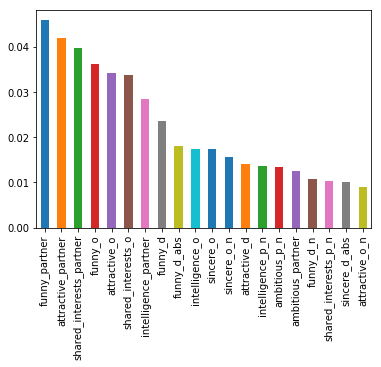

In [24]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [25]:
status, artifact = ds.run_model(dataset_train, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:50:58.06878', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['50f758b28408457a9e60fc3f1f437dce'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:50:58.06878', 'endtime': '2019-04-20T04:51:01.304966', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['50f758b28408457a9e60fc3f1f437dce'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.003871  0.996129
1      1  0.003364  0.996636
2      0  0.999855  0.000145
3      1  0.021667  0.978333
4      0  0.993909  0.006091


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5494
           1       0.98      0.99      0.99      5498

   micro avg       0.99      0.99      0.99     10992
   macro avg       0.99      0.99      0.99     10992
weighted avg       0.99      0.99      0.99     10992



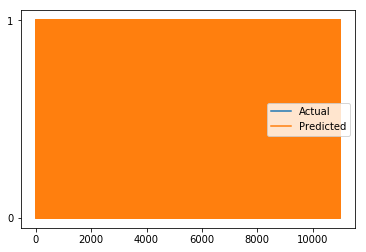

In [26]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [27]:
status, artifact = ds.run_model(dataset_test, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:51:17.284428', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['a1a3c231c92243ac9dcee1927c542930'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:51:17.284428', 'endtime': '2019-04-20T04:51:19.620519', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['a1a3c231c92243ac9dcee1927c542930'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      0  0.999924  0.000076
1      0  0.996561  0.003439
2      1  0.016505  0.983495
3      1  0.236021  0.763979
4      0  0.709961  0.290038


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.62      0.83      0.71      1376
           1       0.74      0.49      0.59      1372

   micro avg       0.66      0.66      0.66      2748
   macro avg       0.68      0.66      0.65      2748
weighted avg       0.68      0.66      0.65      2748



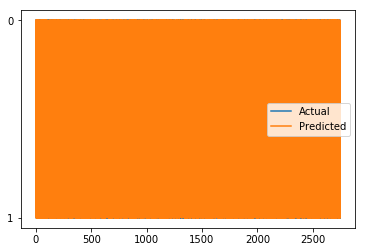

In [28]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

**Model Darwin used**

In [29]:
status, model_type = ds.lookup_model_name(model)
print(model_type)

{'type': 'Supervised', 'updated_at': '2019-04-20T04:51:26.911640', 'trained_on': ['Speed_Dating_Clean_SMOTE_train.csv'], 'loss': 0.22009418408075967, 'generations': 5, 'parameters': {'train_time': '00:10', 'target': 'match', 'recurrent': False, 'max_unique_values': 50, 'max_int_uniques': 15, 'impute': 'mean', 'big_data': False}, 'description': {'best_genome': [{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 358}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 2}}}], 'recurrent': False, 'genome_type': 'DeepNet'}, 'train_time_seconds': 631, 'algorithm': None, 'running_job_id': None}


In [30]:
ds.display_population(model)

(True,
 {'population': {'model_types': {'DeepNeuralNetwork': {'model_description': [{'layer 1': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 140}}},
      {'layer 2': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 676}}},
      {'layer 3': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 2}}}],
     'loss_function': 'CrossEntropy',
     'fitness': -inf},
    'RandomForest': {'model_description': {'type': 'RandomForestClassifier',
      'parameters': {'bootstrap': True,
       'criterion': 'gini',
       'max_depth': 9,
       'max_features': 0.28397226585541957,
       'max_leaf_nodes': None,
       'min_impurity_decrease': 0.0,
       'min_samples_leaf': 10,
       'min_samples_split': 15,
       'n_jobs': -1,
       'min_weight_fraction_leaf': 0.0,
       'n_estimators': 341}},
     'loss_function': 'CrossEntropy',
     'fitness': 1.8812707257389707},
    'GradientBoosted': {'model_desc

# DeepNeuralNetwork

**Analyze DeepNeuralNetwork model**

In [31]:
# Analyze Darwin DeepNeuralNetwork model
status, artifact = ds.analyze_model(model, model_type = 'DeepNeuralNetwork')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T04:51:36.091952', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['9e428bc09fe841a39df7f2001fd2e2dc'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:51:36.091952', 'endtime': '2019-04-20T04:51:46.929648', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['9e428bc09fe841a39df7f2001fd2e2dc'], 'model_name': 'match_model20190420140707', 'job_error': ''}


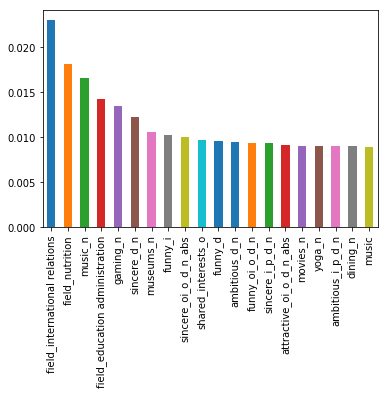

In [32]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [33]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:51:54.008971', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['6346b6b2d48e42f4b268c2b9ead6f437'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:51:54.008971', 'endtime': '2019-04-20T04:51:57.49079', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['6346b6b2d48e42f4b268c2b9ead6f437'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.480264  0.519736
1      1  0.467088  0.532912
2      1  0.448174  0.551826
3      0  0.529738  0.470262
4      1  0.475161  0.524839


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.51      0.19      0.28      5494
           1       0.50      0.81      0.62      5498

   micro avg       0.50      0.50      0.50     10992
   macro avg       0.50      0.50      0.45     10992
weighted avg       0.50      0.50      0.45     10992



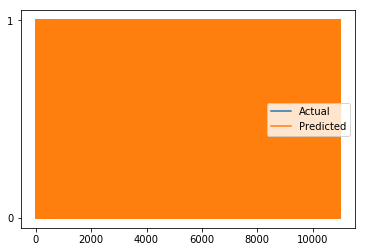

In [34]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [35]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:52:15.243827', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['e5fcfe273ecf459eadfc9b313559b692'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:52:15.243827', 'endtime': '2019-04-20T04:52:16.656205', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['e5fcfe273ecf459eadfc9b313559b692'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.495302  0.504698
1      0  0.523372  0.476628
2      0  0.544092  0.455908
3      0  0.548238  0.451762
4      0  0.507407  0.492593


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.51      0.90      0.65      1376
           1       0.59      0.14      0.23      1372

   micro avg       0.52      0.52      0.52      2748
   macro avg       0.55      0.52      0.44      2748
weighted avg       0.55      0.52      0.44      2748



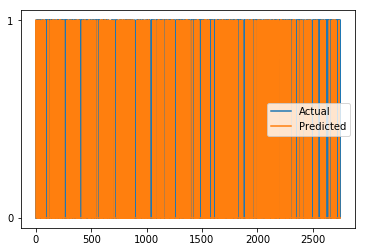

In [36]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# RandomForest

**Analyze RandomForest model**

In [37]:
# Analyze Darwin RandomForest model
status, artifact = ds.analyze_model(model, model_type = 'RandomForest')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T04:52:33.526802', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['61a64fa527ff4d48aaf52f67d8e9f06d'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:52:33.526802', 'endtime': '2019-04-20T04:52:46.990059', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['61a64fa527ff4d48aaf52f67d8e9f06d'], 'model_name': 'match_model20190420140707', 'job_error': ''}


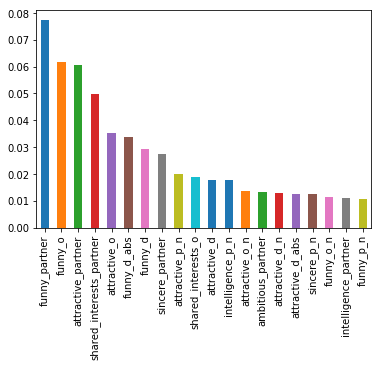

In [38]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [39]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:52:51.476037', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['94a791dfacc54858befe46aa3a89e237'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:52:51.476037', 'endtime': '2019-04-20T04:52:57.754505', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['94a791dfacc54858befe46aa3a89e237'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.082176  0.917824
1      1  0.182339  0.817661
2      1  0.421664  0.578336
3      1  0.348141  0.651859
4      0  0.588710  0.411290


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.94      0.92      0.93      5494
           1       0.92      0.94      0.93      5498

   micro avg       0.93      0.93      0.93     10992
   macro avg       0.93      0.93      0.93     10992
weighted avg       0.93      0.93      0.93     10992



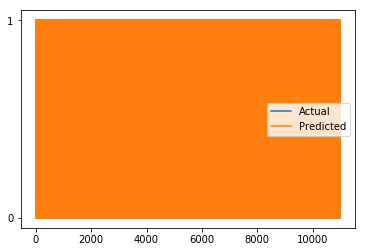

In [40]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [41]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:53:11.137762', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['aa426888d2d7464c8655346086d1ccf2'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:53:11.137762', 'endtime': '2019-04-20T04:53:13.366809', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['aa426888d2d7464c8655346086d1ccf2'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      0  0.904735  0.095265
1      1  0.123744  0.876256
2      1  0.262410  0.737590
3      1  0.112886  0.887114
4      0  0.748917  0.251083


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.90      0.71      0.80      1376
           1       0.76      0.92      0.83      1372

   micro avg       0.82      0.82      0.82      2748
   macro avg       0.83      0.82      0.82      2748
weighted avg       0.83      0.82      0.82      2748



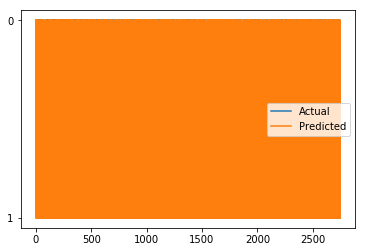

In [42]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# GradientBoosted

**Analyze GradientBoosted model**

In [43]:
# Analyze Darwin GradientBoosted model
status, artifact = ds.analyze_model(model, model_type = 'GradientBoosted')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-20T04:53:29.485083', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['98dc12ebae5d4ff7a576d4b6aa98e5e6'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:53:29.485083', 'endtime': '2019-04-20T04:53:40.377892', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': None, 'artifact_names': ['98dc12ebae5d4ff7a576d4b6aa98e5e6'], 'model_name': 'match_model20190420140707', 'job_error': ''}


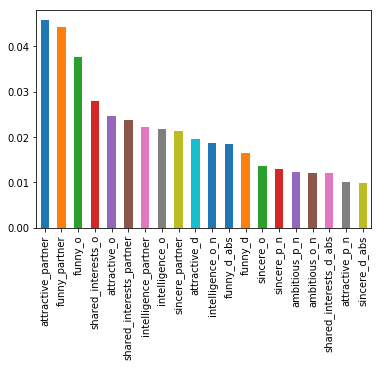

In [44]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [45]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:53:47.4009', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['cde021c169774adb9b75a0063d715fd5'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:53:47.4009', 'endtime': '2019-04-20T04:53:57.558042', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['cde021c169774adb9b75a0063d715fd5'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.003843  0.996157
1      1  0.000210  0.999790
2      0  0.909028  0.090972
3      1  0.001474  0.998526
4      0  0.965982  0.034018


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5494
           1       0.98      0.98      0.98      5498

   micro avg       0.98      0.98      0.98     10992
   macro avg       0.98      0.98      0.98     10992
weighted avg       0.98      0.98      0.98     10992



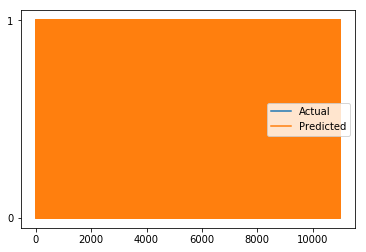

In [46]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [47]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-20T04:54:06.963853', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['ca3a30556e9f482b9fbb7a31d7d08b6f'], 'model_name': 'match_model20190420140707', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T04:54:06.963853', 'endtime': '2019-04-20T04:54:08.587171', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.22009418408075967, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['ca3a30556e9f482b9fbb7a31d7d08b6f'], 'model_name': 'match_model20190420140707', 'job_error': ''}

    match    prob_0    prob_1
0      0  0.679595  0.320405
1      1  0.000700  0.999300
2      1  0.002752  0.997248
3      1  0.000000  1.000000
4      0  0.879480  0.120520


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.95      0.26      0.41      1376
           1       0.57      0.99      0.72      1372

   micro avg       0.62      0.62      0.62      2748
   macro avg       0.76      0.62      0.57      2748
weighted avg       0.76      0.62      0.57      2748



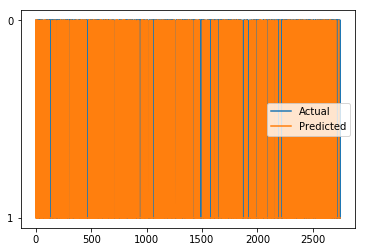

In [48]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# Darwin's hyperparameter

**Looking at the model accuracy with Darwin's selected hyperparameters**

In [50]:
%%time

# DeepNeuralNetwork
scaler = StandardScaler()
clf = MLPClassifier(random_state = 11, hidden_layer_sizes = (140, 676, 2), activation = 'relu')

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 90.02919189390781

Accuracy (train): 98.07132459970887
Classification report (train):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      5494
           1       1.00      0.96      0.98      5498

   micro avg       0.98      0.98      0.98     10992
   macro avg       0.98      0.98      0.98     10992
weighted avg       0.98      0.98      0.98     10992

Accuracy (test): 90.68413391557496
Classification report (test):
               precision    recall  f1-score   support

           0       0.93      0.89      0.90      1376
           1       0.89      0.93      0.91      1372

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

Wall time: 5min 1s


In [51]:
%%time

# RandomForest
scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, bootstrap = True, criterion = 'gini',
                             max_depth = 9, max_features = 0.28397226585541957, max_leaf_nodes = None,
                             min_impurity_decrease = 0.0, min_samples_leaf = 10, min_samples_split = 15,
                             n_jobs = -1, min_weight_fraction_leaf = 0.0, n_estimators = 341)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 82.32355862003648

Accuracy (train): 87.23617176128093
Classification report (train):
               precision    recall  f1-score   support

           0       0.92      0.82      0.86      5494
           1       0.84      0.93      0.88      5498

   micro avg       0.87      0.87      0.87     10992
   macro avg       0.88      0.87      0.87     10992
weighted avg       0.88      0.87      0.87     10992

Accuracy (test): 81.76855895196506
Classification report (test):
               precision    recall  f1-score   support

           0       0.86      0.77      0.81      1376
           1       0.79      0.87      0.83      1372

   micro avg       0.82      0.82      0.82      2748
   macro avg       0.82      0.82      0.82      2748
weighted avg       0.82      0.82      0.82      2748

Wall time: 5min 41s


In [53]:
%%time

# GradientBoosted
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = XGBClassifier(seed = 11, base_score = 0.5, colsample_bylevel = 1,
                    colsample_bytree = 1, gamma = 0, learning_rate = 0.5822052303645006,
                    max_delta_step = 0, max_depth = 8, min_child_weight = 18,
                    n_estimators = 459, n_jobs = -1, reg_alpha = 0,
                    reg_lambda = 1, scale_pos_weight = 1, subsample = 0.5522669403520774)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 89.82914233349881

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 89.8471615720524
Classification report (test):
               precision    recall  f1-score   support

           0       0.93      0.86      0.90      1376
           1       0.87      0.93      0.90      1372

   micro avg       0.90      0.90      0.90      2748
   macro avg       0.90      0.90      0.90      2748
weighted avg       0.90      0.90      0.90      2748

Wall time: 5min
